In [1]:
import tomotopy as tp
import nltk
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import numpy as np

In [21]:
# mdl = tp.CTModel.load('models/wiki_math_subset-CTM-iters_-20-min_cf_-0-min_df_-5-rm_top_-15-num_topics_-25-10.bin')
mdl = tp.CTModel.load('models/wiki_math_subset-CTM-iters-200-min_cf-10-min_df-20-rm_top-50-num_topics-20-2.bin')

In [5]:
print_n_top = 8
for k in range(mdl.k):
    label = "#{}".format(k)
    title= ' '.join(word for word, _ in mdl.get_topic_words(k, top_n=print_n_top))
    print('Topic', label, title)

Topic #0 line triangle angle curve plane points vertices tangent
Topic #1 equation initial solution values end boundary formula equations
Topic #2 turing game american united national war einstein academy
Topic #3 groups algebra element representation lie elements axiom subgroup
Topic #4 algorithm string problem objects equilibrium complexity object algorithms
Topic #5 quantum transform equation momentum angular hash gaussian equations
Topic #6 random process mean sample variables variable variance models
Topic #7 statistical population economic social city political research confidence
Topic #8 tree test player law node null algorithm binary
Topic #9 logic logical entropy rule truth language rules standard
Topic #10 scientific philosophy journal philosophical science research english state
Topic #11 black century ancient greek film modern text gravitational
Topic #12 flow control velocity frame energy digital systems risk
Topic #13 category map topological topology spaces bundle metri

In [6]:
cot_data = pd.read_csv(f'data/cot_data_50_start.csv')

try:
    word_tokenize("test")
except LookupError:
    print('downloading tokenizer...')
    nltk.download('punkt')

In [7]:
from nltk.corpus import stopwords

try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
english_stops = set(stopwords.words('english'))

def tokenize(text):
    return [token for token in text.lower().split() if token.isalpha() and token not in english_stops]

In [9]:
cot_data['Sentences'] = cot_data['CoT Response'].apply(sent_tokenize)

In [11]:
trace_ex = cot_data['Sentences'][0]
trace_ex

["First, let's calculate how many clips Natalia sold in May.",
 'We know that she sold half as many clips in May as she did in April.',
 'So, we can find this by dividing the number of clips she sold in April by 2.',
 '48 clips / 2 = 24 clips\n\nTherefore, Natalia sold 24 clips in May.',
 "Now, let's calculate how many clips she sold altogether in April and May.",
 'We can find this by adding the number of clips she sold in April and the number of clips she sold in May.',
 '48 clips + 24 clips = 72 clips\n\nTherefore, Natalia sold a total of 72 clips in April and May.']

In [12]:
topic_labels = []
for k in range(mdl.k):
    top_words = ' '.join(word for word, _ in mdl.get_topic_words(k, top_n=10))
    topic_labels.append(f"Topic #{k}: {top_words}")

In [13]:
trace_topics = []
for sentence in trace_ex:
    processed_sentence = tokenize(sentence)
    doc = mdl.make_doc(processed_sentence)
    topic_distribution = mdl.infer(doc)
    trace_topics.append(np.argmax(topic_distribution[0]))

In [14]:
trace_topics

[5, 0, 5, 0, 4, 0, 0]

In [18]:
for i, sentence in enumerate(trace_ex):
    print(f'Sentence {i}: ', sentence)
    print(f'Topic {trace_topics[i]} words: ', topic_labels[trace_topics[i]])
    print()

Sentence 0:  First, let's calculate how many clips Natalia sold in May.
Topic 5 words:  Topic #5: quantum transform equation momentum angular hash gaussian equations ratio block

Sentence 1:  We know that she sold half as many clips in May as she did in April.
Topic 0 words:  Topic #0: line triangle angle curve plane points vertices tangent vertex projective

Sentence 2:  So, we can find this by dividing the number of clips she sold in April by 2.
Topic 5 words:  Topic #5: quantum transform equation momentum angular hash gaussian equations ratio block

Sentence 3:  48 clips / 2 = 24 clips

Therefore, Natalia sold 24 clips in May.
Topic 0 words:  Topic #0: line triangle angle curve plane points vertices tangent vertex projective

Sentence 4:  Now, let's calculate how many clips she sold altogether in April and May.
Topic 4 words:  Topic #4: algorithm string problem objects equilibrium complexity object algorithms minimum scheme

Sentence 5:  We can find this by adding the number of clip

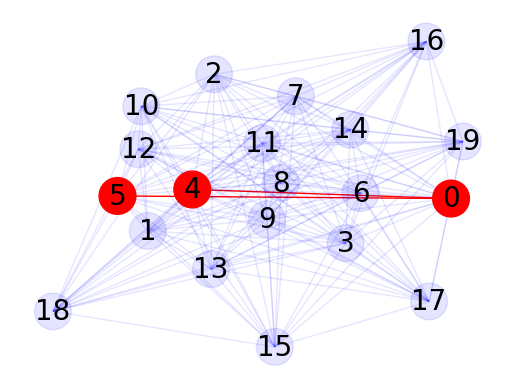

In [20]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

G = nx.Graph()

for k in range(mdl.k):
    G.add_node(k, color=(0, 0, 1, 0.1))

for topic in trace_topics:
    G.nodes[topic]['color'] = 'red'

correlations = mdl.get_correlations().reshape([-1])
correlations.sort()

top_correlations = correlations[-10:]

for k in range(mdl.k):
    for l, correlation in zip(range(k - 1), mdl.get_correlations(k)):
        # if correlation not in top_correlations:
            # continue
        G.add_edge(k, l, weight=float(correlation), color=(0, 0, 1, 0.1))  # default color (transparent blue)

for i in range(len(trace_topics) - 1):
    if G.has_edge(trace_topics[i], trace_topics[i + 1]):
        G[trace_topics[i]][trace_topics[i + 1]]['color'] = 'red'

pos = nx.spring_layout(G)  # positions for all nodes

# nodes
colors = [node[1]['color'] for node in G.nodes(data=True)]
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=700)

# edges
edge_colors = [G[u][v]['color'] for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, edge_color=edge_colors)

# labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')

plt.axis('off')
plt.show()